In [ ]:
!pip install -q clu

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [33]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [34]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [35]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [36]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [37]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [38]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [39]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [40]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [41]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 1000
learning_rate = 5e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 256
expans = 2
n_heads = 1
channel_size = n_embd // n_heads
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(128, 64)
[[ 1 63 53 ... 40 63  1]
 [43  1 52 ... 46 39 42]
 [63  1 45 ... 50  1 61]
 ...
 [46 47 41 ... 58 43  1]
 [ 1 61 43 ... 53 59  1]
 [49  1 58 ... 53 61  1]]
targets:
(128, 64)
[[63 53 59 ... 63  1 58]
 [ 1 52 43 ... 39 42  1]
 [ 1 45 53 ...  1 61 43]
 ...
 [47 41 46 ... 43  1 47]
 [61 43  5 ... 59  1 42]
 [ 1 58 46 ... 61  1 52]]


# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu -->

In [42]:
hidden_state = [jnp.zeros((1,n_latent_dim, n_embd * expans)) for _ in range(n_layers)]

In [43]:
hidden_state[0].shape

(1, 16, 512)

In [44]:
class Mamba(nn.Module):

    def setup(self):
        emb_features = n_embd * expans
        self.in_proj1 = nn.Dense(features=emb_features)
        self.in_proj2 = nn.Dense(features=emb_features)

        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=emb_features,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
        self.B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))

        self.out_proj = nn.Dense(n_embd // n_heads)
        
        self.hidden_state = self.variable('other_variables','hidden_state', 
                                          jnp.zeros, 
                                          (1,n_latent_dim, emb_features))
        self.rms_norm = nn.RMSNorm()

    def __call__(self, embeds):
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)

        x = self.rms_norm(x)

        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.B * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * self.hidden_state.value + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))     
        
        self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
        return jnp.stack(y, -1)

In [45]:
# class MultiHeadMamba(nn.Module):
#     def setup(self):
#         self.layernorm
#         self.heads = [Mamba() for _ in range(n_heads)]
#         self.rms_norm = nn.RMSNorm()

#     def __call__(self, x):
#         out = jnp.concatenate([h(x) for h in self.heads], axis=-1)
#         x = self.rms_norm(out)
#         return x

In [46]:
# class FeedForward(nn.Module):
#     def setup(self):
#         self.ffn = nn.Sequential([
#             nn.Dense(4 * n_embd),
#             nn.relu,
#             nn.Dense(n_embd)]
#         )
#     def __call__(self, x):
#         return self.ffn(x)

In [47]:
# class MambaBlock(nn.Module):
#     def setup(self):
#         self.mamba_block = Mamba()
#         self.ln1 = nn.RMSNorm()
#         self.ffn = FeedForward()
#         self.ln2 = nn.LayerNorm()

#     def __call__(self, x):
#         x = x + self.mamba_block(self.ln2(x))
#         x = x + self.ffn(self.ln1(x))
#         return x


In [48]:
# class MambaModel(nn.Module):

#     def setup(self):
#         self.tok_embeddings = nn.Embed(vocab_size, n_embd)
#         self.pos_embeddings = nn.Embed(block_size, n_embd)
#         self.ln = nn.LayerNorm()
#         self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
#         self.preds_out = nn.Dense(vocab_size)

#     def __call__(self, x, training: bool):
#         x = self.tok_embeddings(x) + self.pos_embeddings(jnp.arange(block_size))
# #         x = self.ln(x)
#         for layer in self.mamba_layers:
#             x = layer(x)
            
#         return self.preds_out(x)

#     @jax.jit
#     def generate(self, idx, max_new_tokens, params):
#     # idx is (B, T) array of indices in the current context
#         for _ in range(max_new_tokens):
#             # crop idx to the last block_size tokens
#             idx_cond = idx[:, -block_size:]
#             # get the predictions
#             logits = self.apply(params, idx_cond)
#             # focus only on the last time step
#             logits = logits[:, -1, :] # becomes (B, C)
#             # apply softmax to get probabilities
#             ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
#             # sample from the distribution
#             idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
#             # append sampled index to the running sequence
#             idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
#     #         print(idx_next)
#     #         print(idx)

#         return idx

In [49]:
# model = Mamba()
# params = model.init(jax.random.key(42), jnp.ones((1,64,256)))
# # print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# # print(model.tabulate(jax.random.key(0), jnp.ones((1,64,256)),
# #                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, jnp.ones((1,64,256)), mutable=['other_variables'])
# # # print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# xb.shape, xs[0].shape, xs[1].keys()

In [50]:
# print(xs[1]['other_variables']['hidden_state'].shape, xs[1]['other_variables']['hidden_state'].min(), xs[1]['other_variables']['hidden_state'].max())

In [51]:
# xfs = model.apply(params, 2*jnp.ones((1,64,256)), mutable=['other_variables'])
# print(params['other_variables']['hidden_state'].shape, params['other_variables']['hidden_state'].min(), params['other_variables']['hidden_state'].max())
# print(xfs[1]['other_variables']['hidden_state'].shape, xfs[1]['other_variables']['hidden_state'].min(), xfs[1]['other_variables']['hidden_state'].max())

In [52]:
# test_model = Mamba()
# test_params = test_model.init(jax.random.key(42), xb)
# n_params = sum(p.size for p in jax.tree_util.tree_leaves(test_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = test_model.apply(test_params, xb)
# xb.shape, xf.shape

In [53]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(self.block_size))
        
        for i in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
#             x = x + nn.MultiHeadDotProductAttention(
#               num_heads=self.num_heads,
#               qkv_features=self.head_size,
#               out_features=self.head_size * self.num_heads,
#               dropout_rate=self.dropout_rate,
#             )(
#               x_norm,
#               x_norm,
#               mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
#               deterministic=not training,
#             )
            x_mamba = Mamba()(x_norm)
    
            x = x + x_mamba

            x = x + nn.Sequential([
              nn.Dense(4 * self.embed_size),
              nn.relu,
              nn.Dropout(self.dropout_rate, deterministic=not training),
              nn.Dense(self.embed_size),
            ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [54]:
# key = jax.random.key(42)

# # fin_model = MambaModel()
# # fin_params = fin_model.init(key, xb, training=False)


# fin_model = NanoLM(
#     vocab_size=vocab_size,
#     num_layers=n_layers,
#     num_heads=8,
#     head_size=32,
#     dropout_rate=0.2,
#     embed_size=n_embd,
#     block_size=block_size,
# )

# fin_params = fin_model.init(
#     {'params': key},
#     jnp.ones((batch_size, block_size), dtype=jnp.int32),
#     training=False
# )

# n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
# print(f"Total number of parameters: {n_params:_}")
# # print(fin_model.tabulate(jax.random.key(42), xb,
# #                    compute_flops=True, compute_vjp_flops=True))
# xf = fin_model.apply(fin_params, xb, training=False)[0]
# xb.shape, xf.shape

In [55]:
def loss_fun(params, x, y, var_params,dropout_key):
    logits, updated_variables = model.apply({'params': params, **var_params}, x, training=True, rngs={"dropout": dropout_key}, mutable=['other_variables'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), (updated_variables, accuracy)

@jax.jit
def eval_step(params, x, y, var_params):
    logits, _ = model.apply({'params': params, **var_params}, x, training=False, mutable=['other_variables'])
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [56]:
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)

model = NanoLM(
    vocab_size=vocab_size,
    num_layers=n_layers,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=n_embd,
    block_size=block_size,
)

var_params = model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)
print(var_params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

dict_keys(['params', 'other_variables'])
Total number of parameters: 7_088_193


In [57]:
params = var_params.pop('params')

In [58]:
var_params = jax.tree_map(lambda x: jnp.zeros_like(x), var_params)

In [59]:
opt = optax.adamw(learning_rate=learning_rate)

opt_state = opt.init(params)

In [60]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, var_params, opt_state):
    key, subkey = jax.random.split(key)
    xb, yb = get_batch(key, train_data)
    (loss, aux_data), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb, var_params, subkey)
    var_params, train_accuracy = aux_data
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, key, opt_state, loss, var_params, train_accuracy

for i in tqdm(range(max_iters)):

    params, key, opt_state, loss, var_params, train_accuracy = step(key, params, var_params, opt_state)
    

    # once every N_FREQ_EVAL we compute loss on the validation set
    if i % eval_iters == 0:
        key, subkey = jax.random.split(key)
        eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data), var_params)
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print(f"Step: {i}\t train loss: {loss}\t train accuracy: {train_accuracy}")
        print(f"Step: {i}\t eval loss: {eval_loss}\t eval accuracy: {eval_accuracy}")
        

  1%|          | 8/1000 [01:06<1:40:44,  6.09s/it] 

Step: 0	 train loss: 4.744095802307129	 eval loss: 4.0755133628845215
Step: 0	 train accuracy: 0.0113525390625	 eval accuracy: 0.1097412109375


 11%|█         | 109/1000 [01:16<01:11, 12.39it/s]

Step: 100	 train loss: 0.07213015854358673	 eval loss: 0.06427407264709473
Step: 100	 train accuracy: 0.9849853515625	 eval accuracy: 0.986328125


 21%|██        | 209/1000 [01:25<01:03, 12.56it/s]

Step: 200	 train loss: 0.042985282838344574	 eval loss: 0.04612626135349274
Step: 200	 train accuracy: 0.9888916015625	 eval accuracy: 0.98828125


 31%|███       | 309/1000 [01:34<00:55, 12.55it/s]

Step: 300	 train loss: 0.04279549419879913	 eval loss: 0.039392128586769104
Step: 300	 train accuracy: 0.9892578125	 eval accuracy: 0.9886474609375


 41%|████      | 409/1000 [01:43<00:47, 12.54it/s]

Step: 400	 train loss: 0.035088278353214264	 eval loss: 0.03510669246315956
Step: 400	 train accuracy: 0.9901123046875	 eval accuracy: 0.9898681640625


 51%|█████     | 509/1000 [01:52<00:39, 12.55it/s]

Step: 500	 train loss: 0.036840327084064484	 eval loss: 0.0341205969452858
Step: 500	 train accuracy: 0.9886474609375	 eval accuracy: 0.9898681640625


 61%|██████    | 609/1000 [02:01<00:31, 12.54it/s]

Step: 600	 train loss: 0.036546871066093445	 eval loss: 0.03932521492242813
Step: 600	 train accuracy: 0.9896240234375	 eval accuracy: 0.9886474609375


 71%|███████   | 709/1000 [02:11<00:23, 12.54it/s]

Step: 700	 train loss: 0.0341481938958168	 eval loss: 0.035788968205451965
Step: 700	 train accuracy: 0.990478515625	 eval accuracy: 0.989501953125


 81%|████████  | 809/1000 [02:20<00:15, 12.54it/s]

Step: 800	 train loss: 0.03476381301879883	 eval loss: 0.03391360118985176
Step: 800	 train accuracy: 0.990234375	 eval accuracy: 0.989990234375


 91%|█████████ | 909/1000 [02:29<00:07, 12.54it/s]

Step: 900	 train loss: 0.03463343158364296	 eval loss: 0.03261871635913849
Step: 900	 train accuracy: 0.9903564453125	 eval accuracy: 0.989990234375


100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]

CPU times: user 2min 2s, sys: 34.8 s, total: 2min 37s
Wall time: 2min 37s


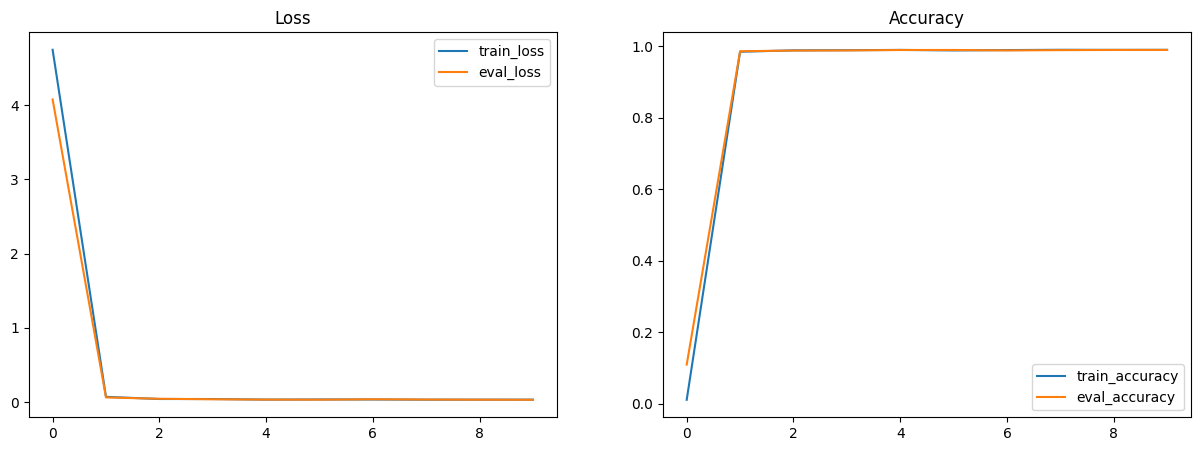

<Figure size 640x480 with 0 Axes>

In [62]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [63]:
@partial(jax.jit, static_argnames=("length"))
def generate_text(rng, params, var_params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = model.apply({'params': params, **var_params}, context, training=False, mutable=['other_variables'])[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

In [64]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, params, var_params, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 33, 15, 20, 17, 31, 23, 10, 0, 27, 44, 53, 50, 52, 1, 57, 53, 1, 51, 39, 63, 1, 60, 47, 41, 43, 47, 52, 1, 63, 53, 59, 42, 1, 46, 39, 40, 58, 57, 6, 0, 30, 39, 39, 57, 57, 1, 39, 57, 1, 58, 53, 1, 44, 39, 59, 49, 8, 0, 0, 25, 17, 27, 10, 0, 32, 46, 63, 8, 0, 0, 23, 21, 26, 16, 17, 16, 35, 21, 26, 21, 33, 31, 10, 0, 25, 39, 63, 6, 1, 58, 53, 1, 61, 39, 49, 43, 56, 50, 39, 56, 57, 58, 1, 40, 43, 39, 57, 1, 40, 53, 51, 43, 1, 58, 53, 1, 58, 46, 43, 1, 61, 46, 39, 58, 1, 39, 52, 42, 1, 61, 43, 57, 1, 63, 53, 59, 1, 58, 46, 53, 59, 49, 1, 53, 44, 1, 42, 53, 1, 51, 59, 41, 49, 1, 58, 53, 12, 0, 0, 22, 33, 23, 17, 24, 27, 10, 0, 32, 53, 1, 47, 58, 1, 61, 46, 39, 58, 58, 43, 56, 52, 8, 0, 21, 1, 41, 53, 59, 45, 46, 58, 1, 63, 53, 59, 1, 53, 44, 1, 47, 52, 0, 32, 46, 39, 58, 1, 51, 39, 52, 1, 39, 58, 1, 42, 43, 45, 56, 53, 51, 0, 32, 53, 1, 58, 53, 1, 39, 56, 56, 43, 57, 58, 1, 49, 52, 39, 58, 1, 54, 56, 39, 51, 6, 0, 13, 6, 1, 39, 42, 1, 53, 44, 1, 59, 52, 57, 59, 47, 56, 42, 6, 1, 52, 53

In [ ]:
dsfsdhfgjdg hfdgjdgjgfjhs'####################

In [ ]:
jax.nn.standardize(jnp.array([2.0,3.0,4.0]))

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [ ]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32), 
                         training=False)['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [ ]:
TrainState.create(

In [ ]:
@jax.jit
def train_step(state, inputs, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs, training=True, 
                                rngs={"dropout": key})[0]
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [ ]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs, training=False)[0]
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [ ]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [ ]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [ ]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [ ]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results...

      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb)
    state = compute_metrics(state=state, inputs=xb, targets=yb)

    key = (jax.random.split(key)[0])

    if step == 0 or (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

In [ ]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [ ]:

logits = fin_model.apply(fin_params, xb, training=False)[0]
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

In [ ]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)

#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)


#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx

In [ ]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context, training=False)[0]
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

In [ ]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

In [ ]:
sdgh  fs

In [ ]:
state.params

In [ ]:
!pip install mamba-ssm

In [ ]:
ones = lambda *size: torch.ones(*size).float().cuda()
zeros = lambda *size: torch.zeros(*size).float().cuda()
arange = lambda n: torch.arange(n).float().cuda()
rand = lambda size: torch.rand(*size).abs().float().cuda()

def create_torch(S = 128, Ba = 2, D = 4, N = 4):
    x = rand((Ba, 1, D, S))
    a = -ones((Ba, N, D, 1))
    b = ones((Ba, N, 1, S)) * 0.1
    c = rand((Ba, N, 1, S)) * 0.1
    delta = rand((Ba, 1, D, S)) * 0.1
    return x, a, b, c, delta

In [ ]:
import selective_scan_cuda

xx, aa, bb, cc, ddelta = create_torch()
y_from_repo = selective_scan_cuda.fwd(xx.squeeze(1), ddelta.squeeze(1), aa[0].squeeze(-1).T, bb.squeeze(-2)[:, None, :, :], cc.squeeze(-2)[:, None, :, :], None, None, None, False)
y_from_repo

In [ ]:
def discretize(a, b, delta):
    da = delta * a
    a_ = jnp.exp(da)
    b_ = b * delta
    return a_, b_

def ssm(x, a, b, c, delta):
    "Jax Implementation"
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(x.shape[-1]):
        h = a_[..., k] * h + b_[..., k] * x[..., k]
        y.append((c[..., k] * h).sum(1, keepdims=True))
    return h, jnp.stack(y, -1)


In [ ]:
_, y_ = ssm(xx.cpu().numpy(), aa.cpu().numpy(), bb.cpu().numpy(), cc.cpu().numpy(), ddelta.cpu().numpy())

In [ ]:
from mamba_ssm import Mamba as Mamba_T
torch_mamba = Mamba_T(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embd, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
)

In [ ]:
xm = x = rand((1, 1, n_embd, 32))
xm.shape

In [ ]:
torch_mamba(xm.squeeze(1))

In [ ]:
torch_mamba.in_proj

In [ ]:
y_mamba_repo = mamba_inner_fn()

In [ ]:
xm.squeeze(1).shape